In [1]:
from molmap import loadmap
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, log_loss
import warnings, os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import copy
from tqdm import tqdm


warnings.filterwarnings("ignore")

from matplotlib.ticker import FormatStrFormatter
#gfc = gfc.rename(columns = {'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'})

sns.set(style='white',  font='sans-serif', font_scale=2)  

In [2]:
df_p_all = pd.read_excel('./41591_2019_406_MOESM5_ESM.xlsx',sheet_name='Panel_d', index_col = 'Species')
df = pd.read_excel('./41591_2019_406_MOESM5_ESM.xlsx',sheet_name='Panel_b', index_col = 'Species')
df_fc = df[df.columns[:5]]
df_p = df[df.columns[5:]]


In [3]:
df_imp = pd.read_excel('../results/feature_importance.xlsx',index_col=0)
df_imp = df_imp.sort_values(['grid_y', 'grid_x'])
idxes = []
for i, j in enumerate(df_imp.index):
    if j == 0:
        idx = 'NaN-%s' % i
    else:
        idx = j
    idxes.append(idx)
df_imp.index = idxes

mp = loadmap('../model/aggmap.mp')

In [4]:
dfx0 = pd.read_excel('../CRC.xlsx', sheet_name='data')
dfx0 = dfx0[dfx0.columns[1:]]
dfx = np.log(dfx0 + 1e-8)

feature_groups_df = pd.read_excel('../CRC.xlsx', sheet_name='feature_info')
feature_group_list = feature_groups_df.Group.tolist()

dfy_all = pd.read_excel('../CRC.xlsx', sheet_name='sample_info')
dfy = pd.get_dummies(dfy_all['Group'])


In [20]:
dfinfo = dfx.join(dfy_all[['Country', 'Group']])

In [21]:
# from sklearn.preprocessing import StandardScaler
# scaler  = StandardScaler()
# t = scaler.fit_transform(dfinfo[dfinfo.columns[:-2]])
# dfinfo.iloc[:,:-2] = t

## Two-sided Wilcoxon test , FDR correlation < 1e-5


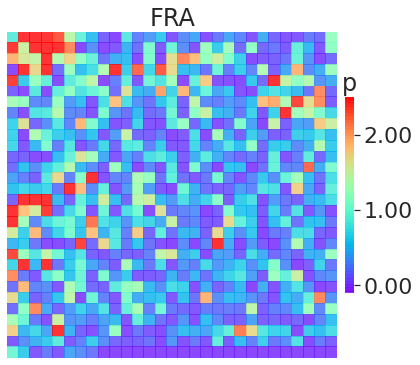

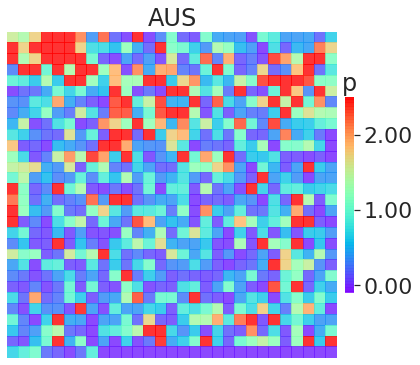

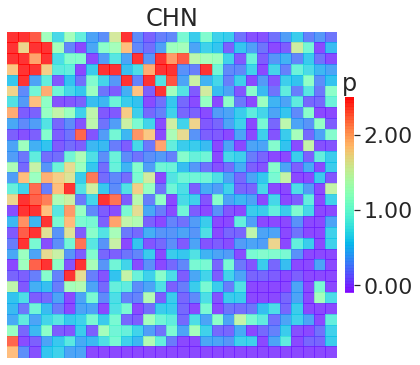

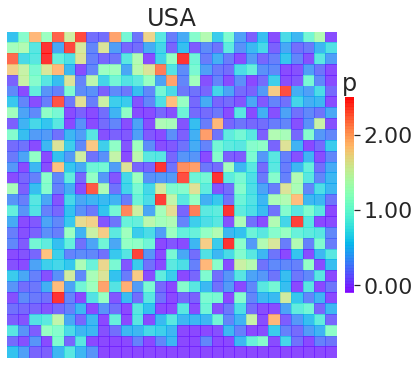

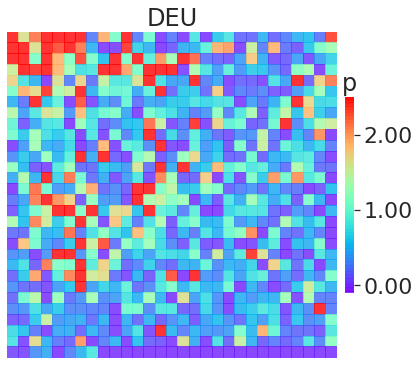

In [22]:
from scikit_posthocs import posthoc_wilcoxon, posthoc_mannwhitney
from matplotlib.colors import LogNorm, Normalize

allps = []
for Country in dfinfo.Country.unique():
    a = dfinfo[dfinfo.Country == Country]
    ps = {}
    for col in a.columns[:-2]:
        try:
            res = posthoc_mannwhitney(a = a, val_col = col, group_col = 'Group', p_adjust = 'fdr_bh') #, use_continuity=False
            adj_p = res['CRC'].loc['CTR']
        except:
            adj_p = 1
        ps[col] = adj_p

    dfres = pd.Series(ps).to_frame(name = Country)
    allps.append(dfres)
    
adjp = pd.concat(allps, axis=1)
adjp = adjp.rename(columns = {'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'})

for country in  adjp.columns:

    fig, ax  = plt.subplots(1, 1, figsize=(6.5, 6))

    imp = pd.DataFrame(index=df_imp.index).join(adjp).loc[df_imp.index][country].values
    imp = np.nan_to_num(imp, nan = 1.0)
    
    imp = -np.log10(imp)
    
    vmax = int(pd.Series(imp).sort_values(ascending=False).head(20).mean())
    
    sns.heatmap(imp.reshape(*mp.fmap_shape),  
                cmap = 'rainbow', alpha = 0.8, ax =ax, yticklabels=0, xticklabels=0, 
                 vmax=2.5, vmin=-0.1,  #norm=Normalize(imp.min(),imp.max()), vmax=vmax, 
                cbar_kws = {'fraction':0.07, 'shrink':0.6, 
                            'aspect': 20, 'pad':0.02, #"ticks":[1, 1.01],
                            #'orientation':'horizontal'
                           }
               )

    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)

    ax.set_title(country)
    cbar = ax.collections[0].colorbar
    cbar.ax.set_title('p',) # rotation=90,
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
        
    cbar.ax.locator_params(nbins=3)
    
    plt.subplots_adjust(wspace = 0.18)

    plt.savefig('./fig/Adjp_%s.pdf' % country, dpi = 400, bbox_inches="tight")

# median-based generalized fold change

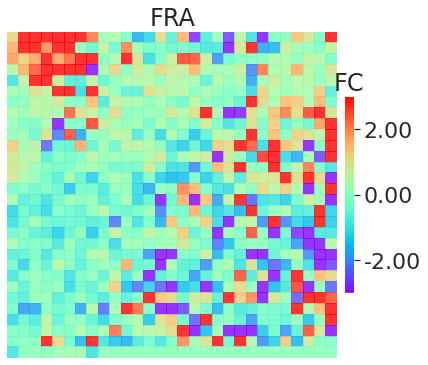

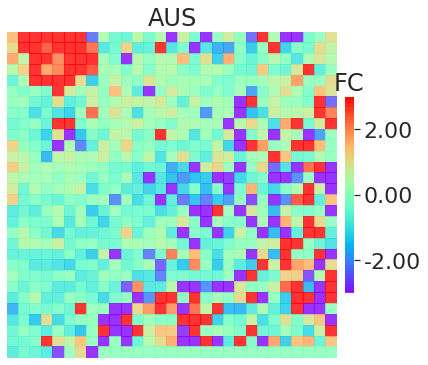

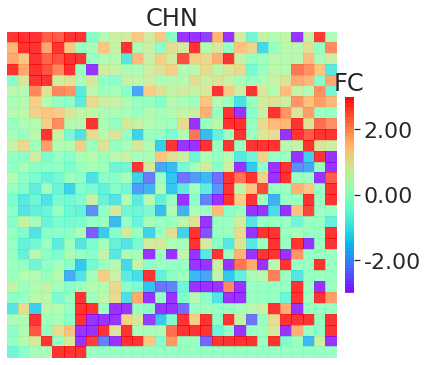

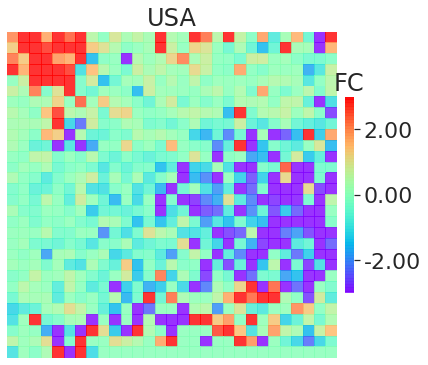

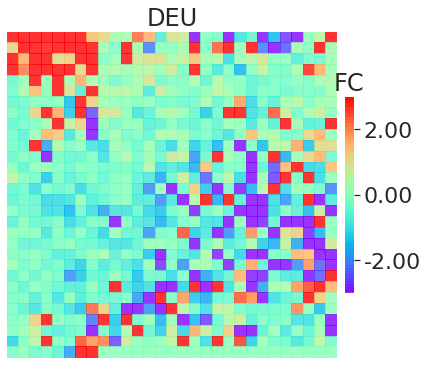

In [23]:
def _get_fc(df):
    return df.apply(lambda x:x.unique()).apply(lambda x:np.mean(x))
median = dfinfo.groupby(['Country', 'Group']).apply(_get_fc)  

fc = []
for c in dfinfo.Country.unique():
    res = median.loc[c, 'CRC'] - median.loc[c,'CTR']
    fc.append(res.to_frame(name=c))
gfc = pd.concat(fc, axis=1)
gfc = gfc.rename(columns = {'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'})

for country in  gfc.columns:

    fig, ax  = plt.subplots(1, 1, figsize=(6.5, 6))

    imp = pd.DataFrame(index=df_imp.index).join(gfc).loc[df_imp.index][country].values
    
    imp = np.nan_to_num(imp, nan = 0.0)
    
    sns.heatmap(imp.reshape(*mp.fmap_shape),  
                cmap = 'rainbow', alpha = 0.8, ax =ax, yticklabels=0, xticklabels=0, 
                vmax=3, vmin=-3,  #norm=Normalize(imp.min(),imp.max()),
                cbar_kws = {'fraction':0.07, 'shrink':0.6, 
                            'aspect': 20, 'pad':0.02, #"ticks":[1, 1.01],
                            #'orientation':'horizontal'
                           }
               )

    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_title(country)
    
    cbar = ax.collections[0].colorbar
    
    cbar.ax.set_title('FC')
    cbar.ax.locator_params(nbins=3)
    
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    
    plt.subplots_adjust(wspace = 0.18)

    plt.savefig('./fig/FC_%s.pdf' % country, dpi = 400, bbox_inches="tight")

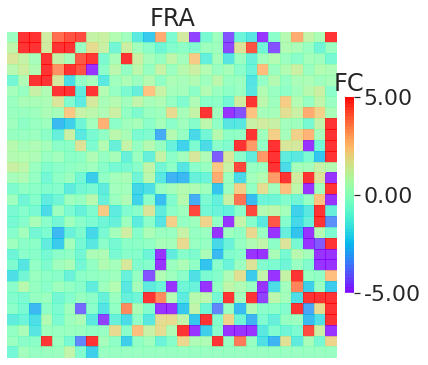

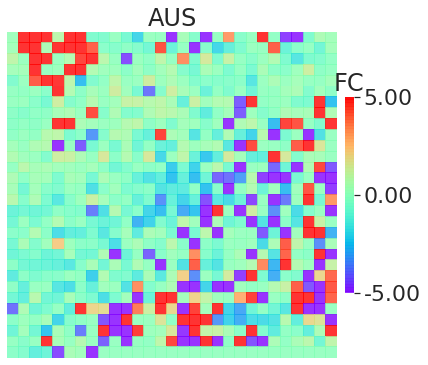

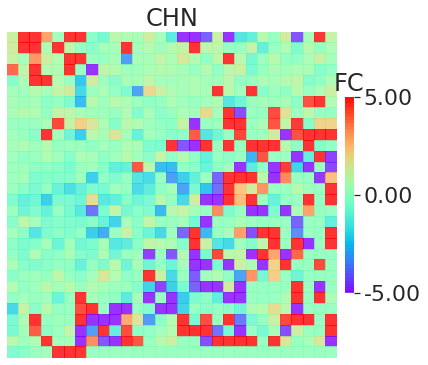

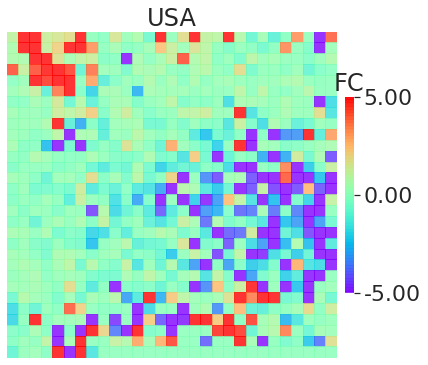

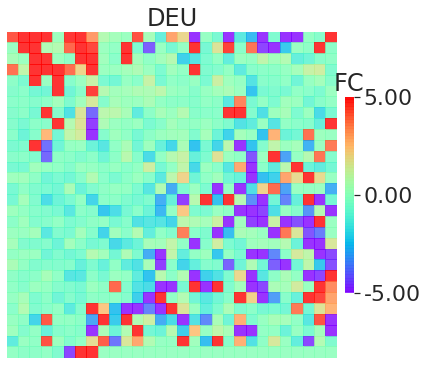

In [24]:
def _get_fc(df):
    return df.apply(lambda x:x.unique()).apply(lambda x:np.median(x))
median = dfinfo.groupby(['Country', 'Group']).apply(_get_fc)  

fc = []
for c in dfinfo.Country.unique():
    res = median.loc[c, 'CRC'] - median.loc[c,'CTR']
    fc.append(res.to_frame(name=c))
gfc = pd.concat(fc, axis=1)
gfc = gfc.rename(columns = {'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'})

for country in  gfc.columns:

    fig, ax  = plt.subplots(1, 1, figsize=(6.5, 6))

    imp = pd.DataFrame(index=df_imp.index).join(gfc).loc[df_imp.index][country].values
    
    imp = np.nan_to_num(imp, nan = 0.0)
    
    sns.heatmap(imp.reshape(*mp.fmap_shape),  
                cmap = 'rainbow', alpha = 0.8, ax =ax, yticklabels=0, xticklabels=0, 
                vmax=5, vmin=-5,  #norm=Normalize(imp.min(),imp.max()),
                cbar_kws = {'fraction':0.07, 'shrink':0.6, 
                            'aspect': 20, 'pad':0.02, #"ticks":[1, 1.01],
                            #'orientation':'horizontal'
                           }
               )

    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_title(country)
    
    cbar = ax.collections[0].colorbar
    
    cbar.ax.set_title('FC')
    cbar.ax.locator_params(nbins=3)
    
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    
    plt.subplots_adjust(wspace = 0.18)

    plt.savefig('./fig/FC_%s.pdf' % country, dpi = 400, bbox_inches="tight")

# AggMapNet GFI

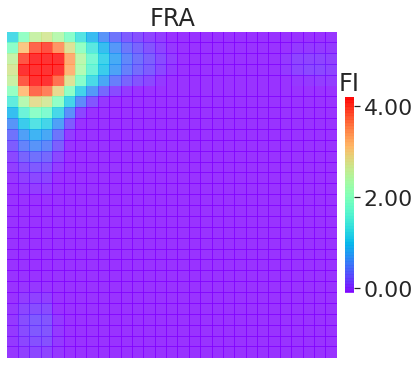

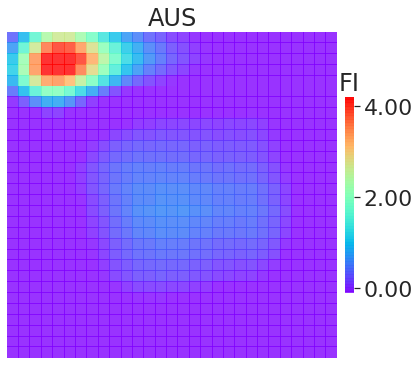

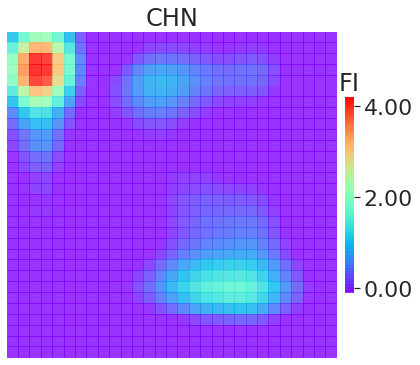

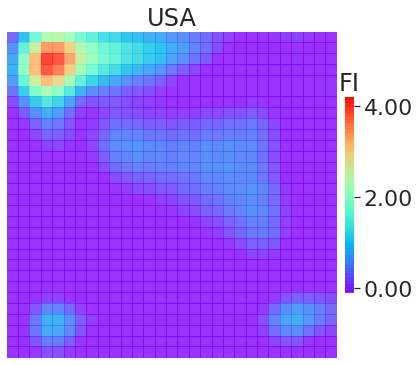

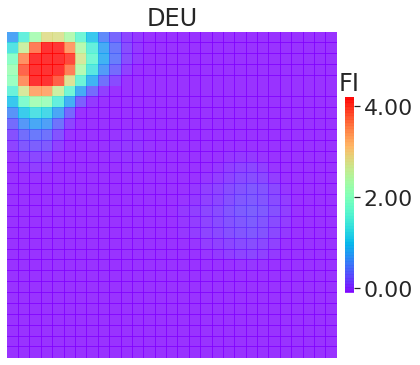

In [54]:
for country in  gfc.columns:

    fig, ax  = plt.subplots(1, 1, figsize=(6.5, 6))

    imp = df_imp[country].values
    
    imp = np.nan_to_num(imp, nan = 0.0)
    
    sns.heatmap(imp.reshape(*mp.fmap_shape),  
                cmap = 'rainbow', alpha = 0.8, ax =ax, yticklabels=0, xticklabels=0, 
                  vmin = -0.1, vmax = 4.2, #norm=Normalize(imp.min(),imp.max()),
                cbar_kws = {'fraction':0.07, 'shrink':0.6, 
                            'aspect': 20, 'pad':0.02, #"ticks":[1, 1.01],
                            #'orientation':'horizontal'
                           }
               )

    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)

    ax.set_title(country)
    cbar = ax.collections[0].colorbar
    
    cbar.ax.set_title('FI')
    
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
        
    cbar.ax.locator_params(nbins=3)
    
    plt.subplots_adjust(wspace = 0.18)

    plt.savefig('./fig/GFI_%s.pdf' % country, dpi = 400, bbox_inches="tight")

In [66]:

gfi = df_imp[gfc.columns]

gfc.to_csv('./fig/00_gfc.csv')
adjp.to_csv('./fig/01_adjp.csv')
gfi.to_csv('./fig/03_gfi.csv')


In [70]:
gfi.corr('spearman')

,FRA,AUS,CHN,USA,DEU
FRA,1.000000,0.449538,0.438748,0.382178,0.611717
AUS,0.449538,1.000000,0.470161,0.462211,0.695960
CHN,0.438748,0.470161,1.000000,0.341339,0.486734
USA,0.382178,0.462211,0.341339,1.000000,0.523487
DEU,0.611717,0.695960,0.486734,0.523487,1.000000


In [71]:
adjp.corr('spearman')

,FRA,AUS,CHN,USA,DEU
FRA,1.000000,0.117325,0.187826,0.086098,0.194589
AUS,0.117325,1.000000,0.046554,0.002027,0.082085
CHN,0.187826,0.046554,1.000000,0.068302,0.197701
USA,0.086098,0.002027,0.068302,1.000000,0.202761
DEU,0.194589,0.082085,0.197701,0.202761,1.000000


In [73]:
gfc.corr('pearson')

,FRA,AUS,CHN,USA,DEU
FRA,1.000000,0.116496,0.171321,0.188010,0.395756
AUS,0.116496,1.000000,0.187300,0.252552,0.187201
CHN,0.171321,0.187300,1.000000,0.120622,0.165707
USA,0.188010,0.252552,0.120622,1.000000,0.254793
DEU,0.395756,0.187201,0.165707,0.254793,1.000000


In [29]:
top=50
for col in gfc.columns:
    s = gfc[col].sort_values(ascending=False)
    idx = s.head(top).index.to_list()
    pd.Series(index=idx).to_csv('./venn/' + 'fc_' + col+'.csv', header=None)
    
for col in adjp.columns:
    s = adjp[col].sort_values(ascending=False)
    idx = s.head(top).index.to_list()
    pd.Series(index=idx).to_csv('./venn/' + 'adjp_' + col+'.csv', header=None)
    
for col in mfi.columns:
    s = mfi[col].sort_values(ascending=False)
    idx = s.head(top).index.to_list()
    pd.Series(index=idx).to_csv('./venn/' + 'gfi_' + col+'.csv', header=None)

In [44]:
res = []
for col in mfi.columns:
    s = mfi[col].sort_values(ascending=False)
    idx = s.head(30).index.to_list()
    res.append(set(idx))

In [73]:
ccs = res[0] & res[1] & res[2] & res[3] & res[4]
mycols = list(ccs)
m1 = mfi.loc[mycols].mean(axis=1).sort_values(ascending=False).index.tolist()
m2 = df_imp.loc[mycols].sort_values(['grid_x','grid_y']).index.tolist()
m = m2

<AxesSubplot:>

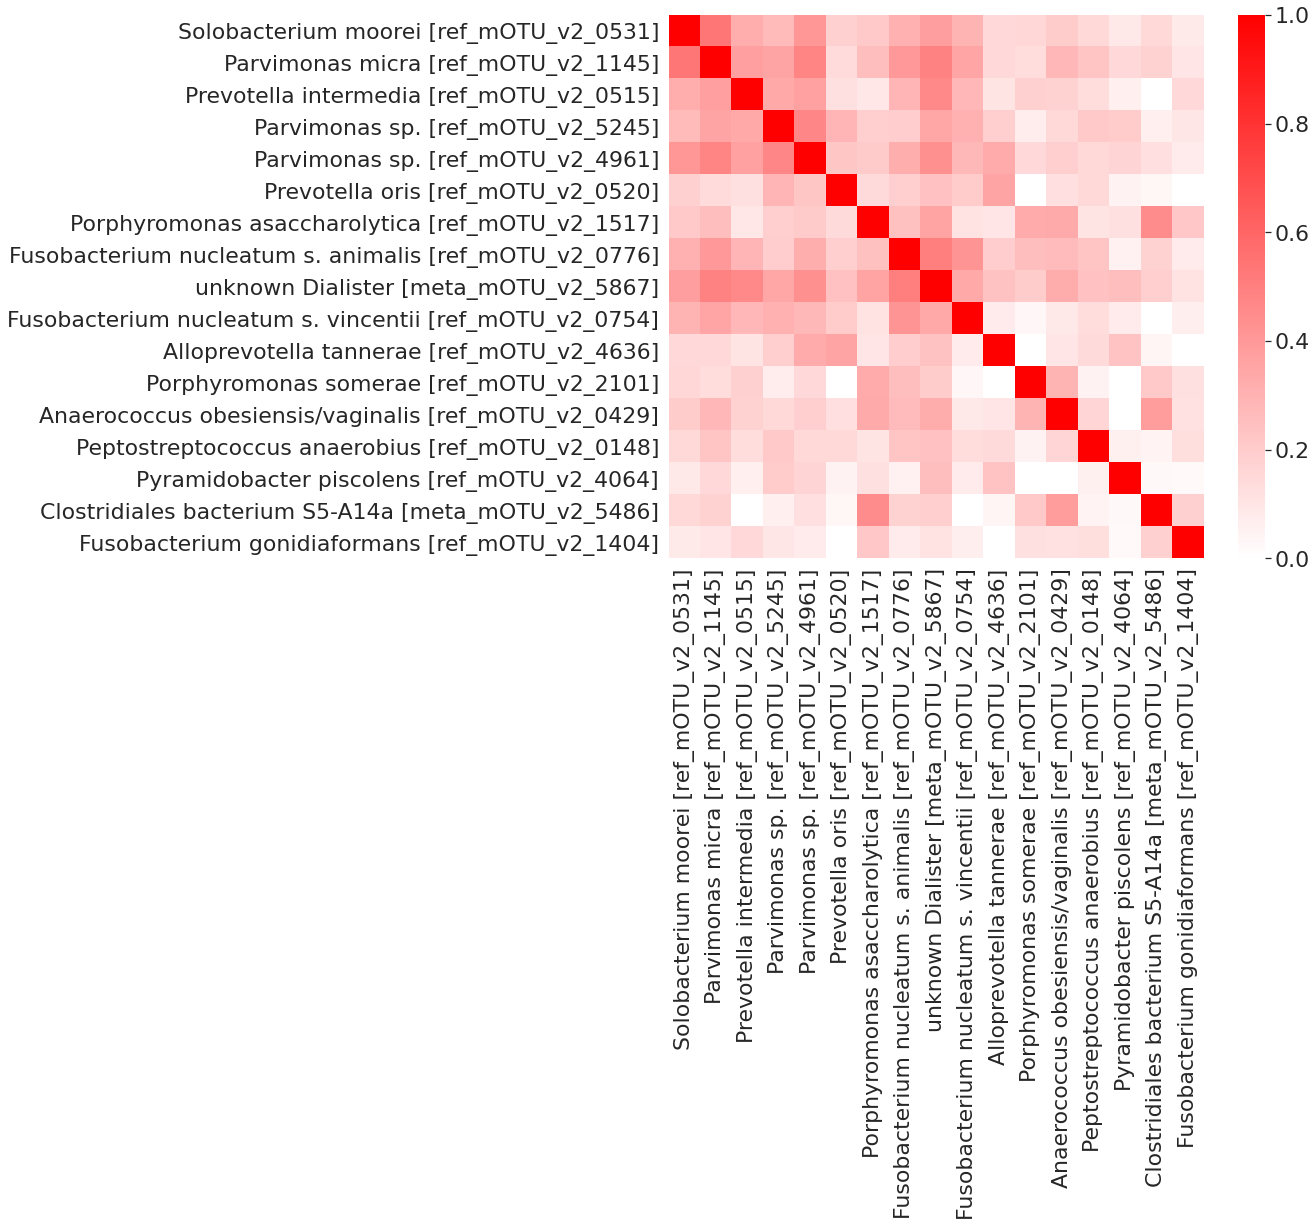

In [77]:
import matplotlib as mpl
vmin = -1 #df_map[weight].iloc[:top].min() 
vmax = 1 #df_map[weight].iloc[:top].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [ "white", "red"], N = 1000, gamma = 1.0)
#cmap = mpl.cm.cool
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(dfx[m].corr(), ax = ax, vmin=0, cmap=cmap)

Porphyromonas asaccharolytica [ref_mOTU_v2_1517]           2.371837
Prevotella intermedia [ref_mOTU_v2_0515]                   3.218373
Fusobacterium gonidiaformans [ref_mOTU_v2_1404]            3.260211
Solobacterium moorei [ref_mOTU_v2_0531]                    3.336336
Clostridiales bacterium S5-A14a [meta_mOTU_v2_5486]        3.380016
Pyramidobacter piscolens [ref_mOTU_v2_4064]                3.405149
Parvimonas micra [ref_mOTU_v2_1145]                        3.456821
Porphyromonas somerae [ref_mOTU_v2_2101]                   3.501926
Fusobacterium nucleatum s. animalis [ref_mOTU_v2_0776]     3.599258
Alloprevotella tannerae [ref_mOTU_v2_4636]                 3.898383
Prevotella oris [ref_mOTU_v2_0520]                         4.033742
Parvimonas sp. [ref_mOTU_v2_5245]                          4.147750
Fusobacterium nucleatum s. vincentii [ref_mOTU_v2_0754]    4.226112
Peptostreptococcus anaerobius [ref_mOTU_v2_0148]           4.227407
Anaerococcus obesiensis/vaginalis [ref_mOTU_v2_0

['Porphyromonas asaccharolytica [ref_mOTU_v2_1517]',
 'Prevotella intermedia [ref_mOTU_v2_0515]',
 'Fusobacterium nucleatum s. animalis [ref_mOTU_v2_0776]',
 'Porphyromonas somerae [ref_mOTU_v2_2101]',
 'Solobacterium moorei [ref_mOTU_v2_0531]',
 'Parvimonas sp. [ref_mOTU_v2_5245]',
 'unknown Dialister [meta_mOTU_v2_5867]',
 'Anaerococcus obesiensis/vaginalis [ref_mOTU_v2_0429]',
 'Clostridiales bacterium S5-A14a [meta_mOTU_v2_5486]',
 'Parvimonas micra [ref_mOTU_v2_1145]',
 'Parvimonas sp. [ref_mOTU_v2_4961]',
 'Fusobacterium nucleatum s. vincentii [ref_mOTU_v2_0754]',
 'Peptostreptococcus anaerobius [ref_mOTU_v2_0148]',
 'Fusobacterium gonidiaformans [ref_mOTU_v2_1404]',
 'Prevotella oris [ref_mOTU_v2_0520]',
 'Alloprevotella tannerae [ref_mOTU_v2_4636]',
 'Pyramidobacter piscolens [ref_mOTU_v2_4064]']

In [16]:
mfi = df_imp[gfc.columns]

,gFC.FR-CRC,gFC.DE-CRC,gFC.CN-CRC,gFC.US-CRC,gFC.AT-CRC
Species,,,,,
unknown Clostridiales [meta_mOTU_v2_6602],-0.661308,-0.183980,-0.689787,-0.139939,-0.219045
unknown Clostridiales [meta_mOTU_v2_6852],-0.497492,-0.339635,-0.465391,-0.176108,-0.159289
unknown Faecalibacterium [meta_mOTU_v2_5815],-0.276326,-0.713935,-0.635114,-0.540567,0.060573
Roseburia intestinalis [ref_mOTU_v2_1427],-0.798053,-0.877873,-0.654431,0.176107,-0.199823
bacterium LF-3 [ref_mOTU_v2_3608],-0.486497,-0.329189,-0.748278,-0.348577,-0.170021
...,...,...,...,...,...
unknown Dialister [meta_mOTU_v2_5867],0.552726,0.408869,0.553332,0.184092,0.206078
Fusobacterium nucleatum s. animalis [ref_mOTU_v2_0776],0.440410,0.413297,0.419212,0.318826,0.439917
Peptostreptococcus stomatis [ref_mOTU_v2_4614],0.439765,0.480281,0.774089,0.171426,0.478785


In [9]:
fc2  = gfc.loc[df_fc.index]
fc2

,FRA,AUS,CHN,USA,DEU
Species,,,,,
unknown Clostridiales [meta_mOTU_v2_6602],-0.735036,-0.483133,-0.906298,-0.053501,-0.364877
unknown Clostridiales [meta_mOTU_v2_6852],-0.651472,-0.804003,-0.138362,-0.332724,-0.513152
unknown Faecalibacterium [meta_mOTU_v2_5815],-0.683039,-0.401703,-1.441024,-1.013399,-1.252113
Roseburia intestinalis [ref_mOTU_v2_1427],-1.016834,-0.462096,-1.050859,0.517085,-1.145599
bacterium LF-3 [ref_mOTU_v2_3608],-0.759898,-0.840250,-0.785183,-0.319413,-0.435639
...,...,...,...,...,...
unknown Dialister [meta_mOTU_v2_5867],10.382093,9.331538,2.508429,5.136454,5.162955
Fusobacterium nucleatum s. animalis [ref_mOTU_v2_0776],1.989302,2.546510,1.841670,2.722775,2.904348
Peptostreptococcus stomatis [ref_mOTU_v2_4614],1.819511,1.782855,1.806667,2.210973,3.335406


,FRA,AUS,CHN,USA,DEU
Species,,,,,
unknown Clostridiales [meta_mOTU_v2_6602],1.459676e-04,6.612075e-02,1.031961e-04,0.609601,3.995318e-01
unknown Clostridiales [meta_mOTU_v2_6852],1.498320e-03,1.436948e-01,1.043192e-03,0.233907,6.729038e-03
unknown Faecalibacterium [meta_mOTU_v2_5815],1.019011e-01,8.628682e-01,1.878629e-05,0.047300,2.927528e-04
Roseburia intestinalis [ref_mOTU_v2_1427],1.823255e-03,3.516330e-01,6.638737e-03,0.399384,3.478663e-04
bacterium LF-3 [ref_mOTU_v2_3608],2.685345e-02,2.953343e-01,1.492609e-04,0.173945,9.035517e-02
...,...,...,...,...,...
unknown Dialister [meta_mOTU_v2_5867],1.753325e-07,4.883402e-05,6.312162e-05,0.001012,1.246233e-06
Fusobacterium nucleatum s. animalis [ref_mOTU_v2_0776],1.160521e-04,1.888437e-06,1.449555e-04,0.001377,1.017015e-05
Peptostreptococcus stomatis [ref_mOTU_v2_4614],1.152539e-02,3.091973e-04,2.540946e-07,0.005346,1.390859e-07


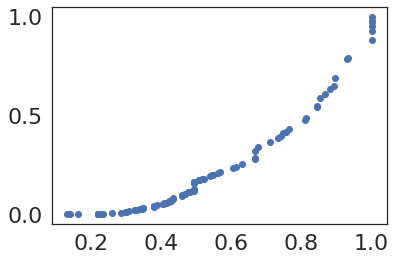

In [49]:
gfc

,FRA,AUS,CHN,USA,DEU
Clostridium saccharogumia [ref_mOTU_v2_0473],-0.357336,-0.794605,3.639521,-0.273990,-0.451404
Clostridium innocuum [ref_mOTU_v2_0643],0.323510,-0.300858,0.447772,0.013930,0.175684
Clostridium sp. KLE 1755 [ref_mOTU_v2_0860],0.412510,0.358636,1.190221,0.697372,-0.056788
Clostridium scindens [ref_mOTU_v2_0883],-0.211111,0.428905,1.350207,0.352967,1.034852
Clostridium boltae/clostridioforme [ref_mOTU_v2_0886],0.343227,0.301463,0.805006,0.469523,0.301408
...,...,...,...,...,...
Veillonella atypica [ref_mOTU_v2_0561],0.514185,0.516481,-0.167619,-0.106987,-0.118356
Veillonella dispar [ref_mOTU_v2_4469],0.613306,0.703076,0.249278,0.145244,-0.581440
Veillonella parvula [ref_mOTU_v2_1042],0.866947,0.521024,0.381388,0.332979,0.628794
Veillonella sp. [ref_mOTU_v2_5068],-0.309092,0.836203,0.030355,-0.286307,-0.537561


In [50]:
dft1 = pd.read_excel('../marker_old_methods/41591_2019_406_MOESM5_ESM.xlsx', index_col='Species',
                     sheet_name='Panel_a').sort_values('-log10(q-value)', ascending=False)
dft2 = pd.read_excel('../results/feature_importance.xlsx', index_col=0)

In [164]:
top=30

t1 = dft1.index[:top]
t2 = dft2.index[:top]

In [165]:
gfc2 = pd.DataFrame(index=df_imp.index).join(gfc)

In [166]:

t1_p = pd.DataFrame(index=df_imp.index).join(gfc2.loc[t1])
t2_p = pd.DataFrame(index=df_imp.index).join(gfc2.loc[t2])


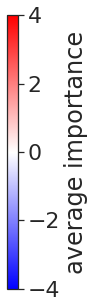

In [167]:
import matplotlib as mpl
vmin = -4 #df_map[weight].iloc[:top].min() 
vmax = 4 #df_map[weight].iloc[:top].max()

fig, ax = plt.subplots(figsize=(0.2, 10))
fig.subplots_adjust(bottom=0.5)


norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["blue", "white","red"], N = 1000, gamma = 1.0)
#cmap = mpl.cm.cool

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm, #orientation='horizontal'
                                )
cb1.set_label('average importance')
fig.show()

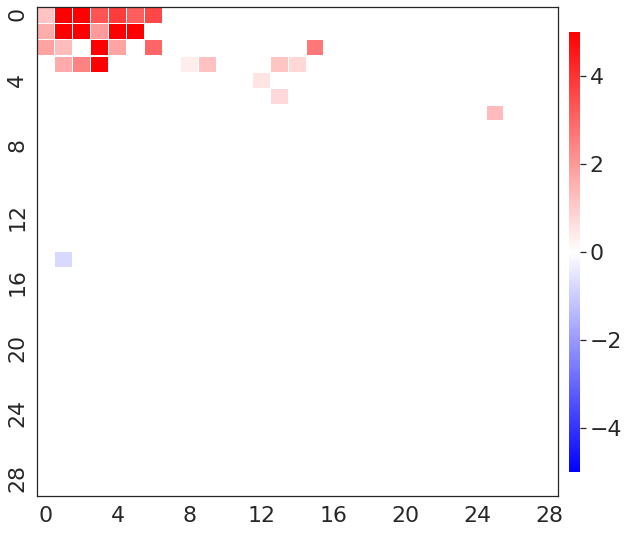

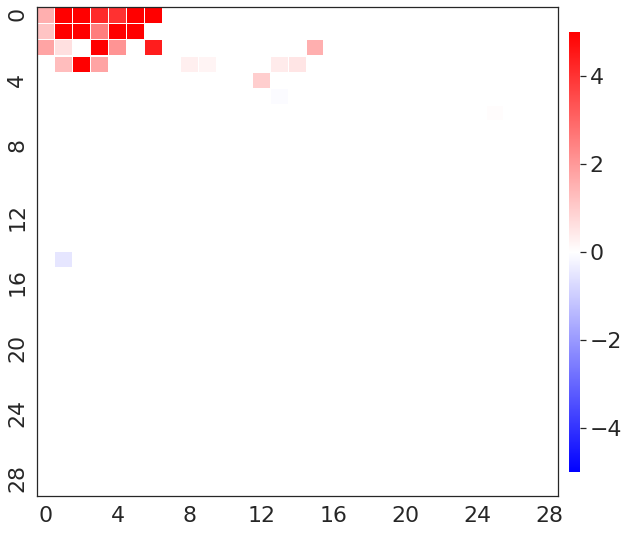

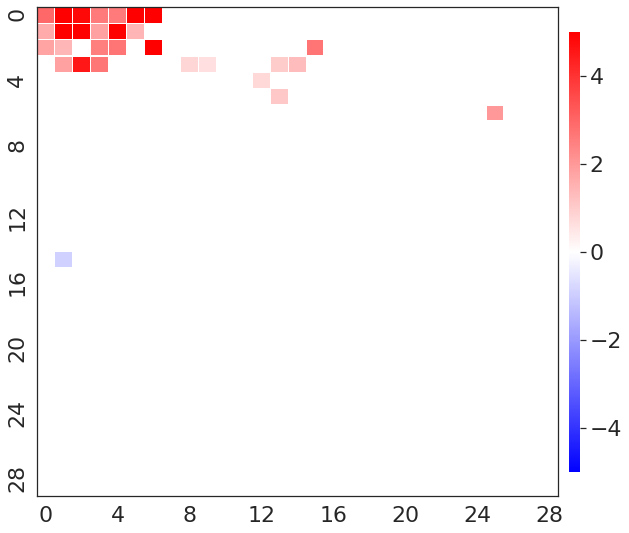

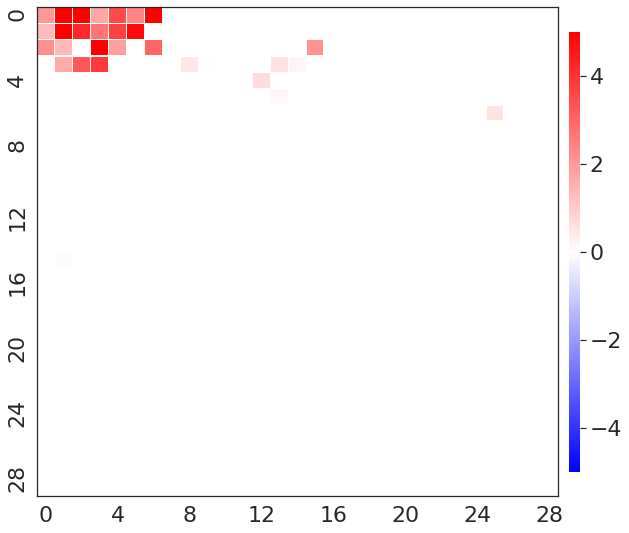

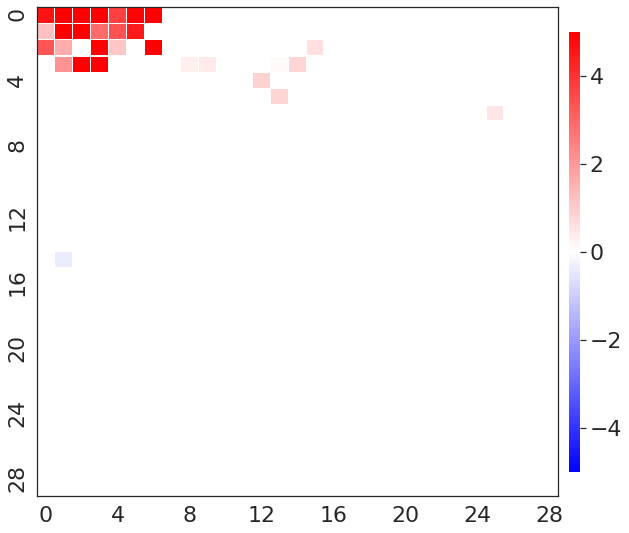

In [168]:
for country in  t1_p.columns:

    fig, ax  = plt.subplots(1, 1, figsize=(10, 9))

    imp = t1_p[country].values
    
    sns.heatmap(imp.reshape(*mp.fmap_shape),  
                cmap = cmap, alpha = 1, xticklabels=4, ax =ax,linewidths=.5,
                yticklabels=4,   vmax=5, vmin=-5, #norm=Normalize(imp.min(),imp.max()), #vmax=8,  vmin=-2,  
                cbar_kws = {'fraction':0.046, 'shrink':0.9, 'aspect': 40, 'pad':0.02, }
               )

    for _, spine in ax.spines.items():
        spine.set_visible(True)

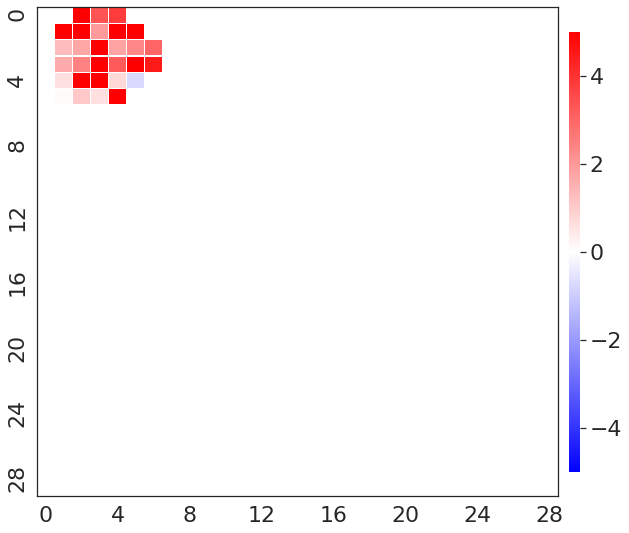

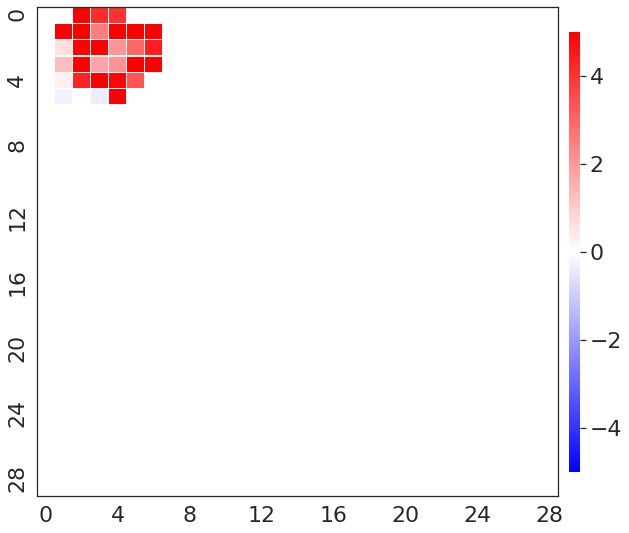

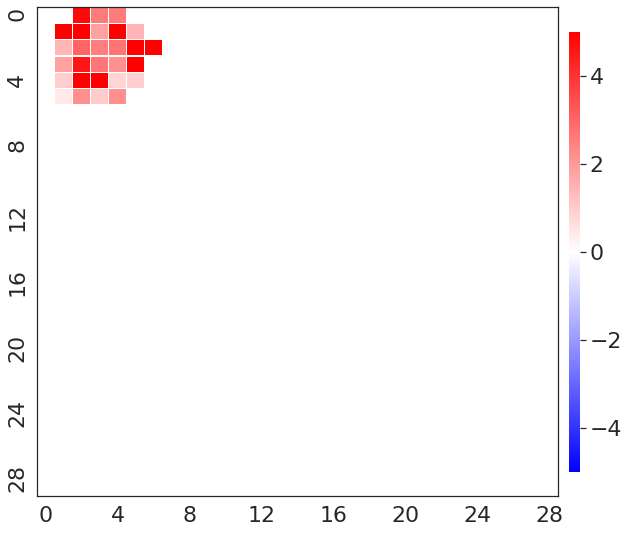

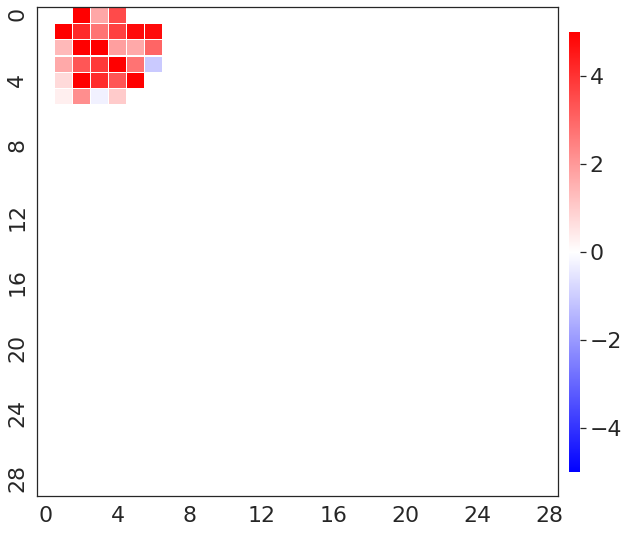

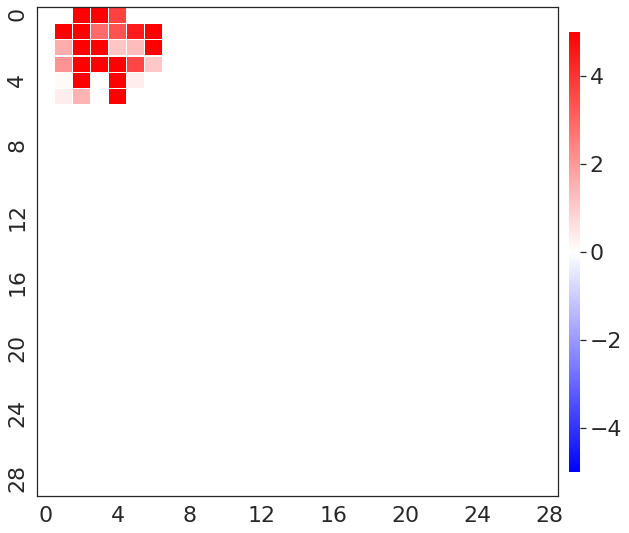

In [169]:
for country in  t2_p.columns:

    fig, ax  = plt.subplots(1, 1, figsize=(10, 9))

    imp = t2_p[country].values

    sns.heatmap(imp.reshape(*mp.fmap_shape),  
                cmap = cmap, alpha = 1, xticklabels=4, ax =ax,linewidths=.5,
                yticklabels=4,   vmax=5, vmin=-5, #norm=Normalize(imp.min(),imp.max()), #vmax=8,  vmin=-2,  
                cbar_kws = {'fraction':0.046, 'shrink':0.9, 'aspect': 40, 'pad':0.02, }
               )

    for _, spine in ax.spines.items():
        spine.set_visible(True)